## Trying out [Fake.br](https://github.com/roneysco/Fake.br-Corpus) dataset



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
DATA_PATH = '../Fake.br-Corpus/preprocessed/pre-processed.csv'

df = pd.read_csv(DATA_PATH, index_col = 'index')
df.head(5)

,label,preprocessed_news
index,,
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   object
 1   preprocessed_news  7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB


In [4]:
df['label'].value_counts()

fake    3600
true    3600
Name: label, dtype: int64

### Transform label to bool

In [5]:
df['target'] = df['label'].map( {'fake': 0, 'true': 1} ).astype(int)

In [6]:
df.head(5)

,label,preprocessed_news,target
index,,,
0,fake,katia abreu diz vai colocar expulsao moldura n...,0
1,fake,ray peita bolsonaro conservador fake entrevist...,0
2,fake,reinaldo azevedo desmascarado policia federal ...,0
3,fake,relatorio assustador bndes mostra dinheiro pub...,0
4,fake,radialista americano fala sobre pt vendem ilus...,0


## Tokenize

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

2021-11-03 07:53:08.440109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 07:53:08.440163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [37]:
num_words = 2000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'


tokenizer=Tokenizer(num_words = num_words, oov_token=oov_token)
tokenizer.fit_on_texts(df['preprocessed_news'].values)
X = tokenizer.texts_to_sequences(df['preprocessed_news'].values)

lens = np.array([len(x) for x in X])
maxlen = int(lens.mean() + 2*lens.std())

X_pad = pad_sequences(X,padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [38]:
X_pad.shape

(7200, 1124)

In [39]:
X_pad

array([[  1,   1,  23, ...,   0,   0,   0],
       [  1,   1, 464, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [  1, 162,  18, ...,   0,   0,   0],
       [487, 397, 279, ...,   0,   0,   0],
       [  1,  78,  23, ...,   0,   0,   0]], dtype=int32)

In [12]:
# split train-test

y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 101)
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

2526
2514


### Let's try out some models!


Mas antes alguns métodos de avaliação.

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Fake', 'True']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

#### Suport Vector Machine

Baseado no notebook *ML_SUP_Categorical_Classification* e nas informações disponíveis na [Motivação para SVM](https://en.wikipedia.org/wiki/Support-vector_machine#Motivation) da Wikipédia.
Tentar usar apenas o filtro linear

In [14]:
from sklearn import model_selection
from sklearn import svm

Classification Report
              precision    recall  f1-score   support

        Fake       0.87      0.90      0.88      1074
        True       0.89      0.86      0.88      1086

    accuracy                           0.88      2160
   macro avg       0.88      0.88      0.88      2160
weighted avg       0.88      0.88      0.88      2160

ROC Score: 0.880178914987088
Accuracy Score: 0.8800925925925925
Average Precision Score: 0.840555831535811
f1 Score: 0.8788020589611605
Confusion matrix, without normalization
[[962 112]
 [147 939]]


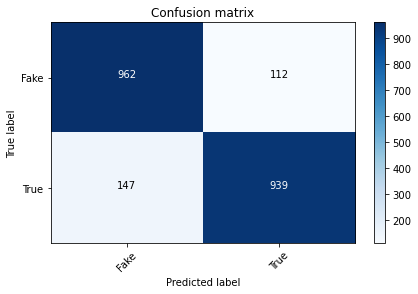

In [18]:
clf_svc2 = svm.SVC(kernel='linear',
                   C=0.9,  
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=0).fit(X_train[1:1000], y_train[1:1000])

roc_svc2 = clf_eval(clf_svc2, X_test, y_test)

### Multilayer perceptron